# Examples: Week 7

This week, we will apply some of our discussions around filtering, splitting and so on to build out comparisons between different variables within the World Bank Economic Indicators dataset.

This dataset, which covers 1960-2016, 264 countries and 1452 variables, can be obtained at the [Worldbank Data site](data.worldbank.org).

In [1]:
%matplotlib inline

Building on our discussion of modules from last week, we'll use the `my_dataset` module that I have prepared as a basis.  This module is largely identical to what we have built out in previous weeks.

In [2]:
import sys
sys.path.insert(0, "/srv/nbgrader/data/WDI/")

from my_dataset import Dataset, read_csv

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
plt.rcParams["figure.figsize"] = (6, 5)

We'll use a `read_csv` function that is provided in our module to feed into a `Dataset` object.  This loads in our full dataset, and we'll take a look at the columns it generates.

Note that we're using a different `encoding`.  In particular, this is because the file is encoded in `cp1252`, which is a Windows-specific extension that includes some characters that can't be interpreted directly in Unicode.  If we didn't specify this, it would crash.

In [4]:
data = Dataset(read_csv("/srv/nbgrader/data/WDI/WDI_Data.csv",
                        encoding="cp1252"))

Let's see what data is available.

In [5]:
data.columns()

dict_keys(['1962', '1987', '1999', '2005', '1977', '1979', '2006', '1985', '2009', '1981', '2012', '1961', '2008', '1982', '1969', '1978', '1998', '2015', '1960', '2016', '1963', '2004', '2000', '1991', '1970', '1993', '1975', '2002', '1983', '1994', '1976', 'Indicator Name', '1984', '2001', '1990', '1989', '1996', '1972', '1971', '1973', '1997', '2014', '2013', '2007', '2010', '1968', '2011', '1967', '1965', '1992', 'Country Name', '1974', 'Indicator Code', '2003', '1986', 'Country Code', '1964', '1980', '1995', '1966', '1988'])

Wow!  OK, so, we have a column for each year that data is available.  Other than that, we have an indicator code, a country code, and then the longer names of those two things.  How many indicator codes are there?  (Spoiler alert: I put the number up above already!)

In [6]:
np.unique(data["Indicator Code"])

array(['AG.AGR.TRAC.NO', 'AG.CON.FERT.PT.ZS', 'AG.CON.FERT.ZS', ...,
       'per_si_allsi.adq_pop_tot', 'per_si_allsi.ben_q1_tot',
       'per_si_allsi.cov_pop_tot'], 
      dtype='<U25')

In [7]:
np.unique(data["Indicator Code"]).size

1452

In [8]:
np.unique(data["Country Code"]).size

264

We'll convert our columns like usual, but this time we'll "blacklist" the ones we *don't* want to convert to float.

In [9]:
mapping = {"Country Code": "str", "Country Name": "str",
           "Indicator Code": "str", "Indicator Name": "str"}
for c in data.columns():
    data.convert(c, mapping.get(c, "float"))

Let's do some checks to make sure we've got a full set of values, by checking that we have N_countries by N_indicators.

In [10]:
data["1964"].shape

(383328,)

In [11]:
383328/264.

1452.0

Awesome, we're good.

It's a bit unwieldy to have a bunch of columns.  We're going to join all the years, in order, so that we can have just a single column for that.  This column will be N-wide, where N is the number of years.

To do this, we'll create a list of arrays, and then use `np.array` to turn them into a single array.

In [12]:
values = []
for i in range(1960, 2017):
    values.append(data[str(i)])
values = np.array(values)

But it's the wrong shape, as we'll see:

In [13]:
values.shape

(57, 383328)

So we'll transpose it (switching first and last axes) and then stick it into our dataset as the column "values".

In [14]:
values = values.transpose()
data.data["values"] = values

Just to make sure, let's double-check that our `values` column shows up.

In [15]:
data.columns()

dict_keys(['1962', '1987', '1999', '2005', '1977', '1979', '2006', '1985', '2009', '1981', '2012', '1961', '2008', '1982', '1969', '1978', '1998', '2015', '1960', '2016', '1963', '2004', '2000', '1991', '1970', '1993', '1975', '2002', '1983', '1994', '1976', 'values', 'Indicator Name', '1984', '2001', '1990', '1989', '1996', '1972', '1971', '1973', '1997', '2014', '2013', '2007', '2010', '1968', '2011', '1967', '1965', '1992', 'Country Name', '1974', 'Indicator Code', '2003', '1986', 'Country Code', '1964', '1980', '1995', '1966', '1988'])

Let's get started.  I've picked out an indicator we can use, which is the population in the largest city.

In [16]:
# EN.URB.LCTY

pop_city = data.filter_eq("Indicator Code", "EN.URB.LCTY")

In [17]:
pop_city["values"].shape

(264, 57)

What's the population in just the US in this city over time?

In [18]:
us_pop_city = pop_city.filter_eq("Country Name", 'United States')

We'll need some years to plot against, so we will use `np.arange` to generate the values to supply to our plotting routines.  This routine drops off the final value, so we have to go to N+1 where N is the final value we want.

In [19]:
years = np.arange(1960, 2017)

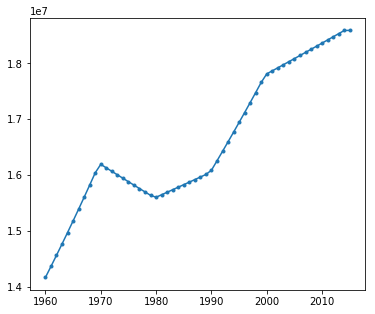

In [20]:
plt.plot(years, us_pop_city["values"][0,:], '.-')

Great.  That kind of works as we want.  Now let's clean it up, put it in a function, and look at a couple different countries.  And, while we're at it, we'll go ahead and make the indicator name a parameter, too.

We'll plug this into the `ipywidgets.interact` function momentarily.

In [21]:
def plot_country_indicator(country, indicator):
    indicator_value = data.filter_eq("Indicator Name", indicator)
    country_value = indicator_value.filter_eq("Country Name", country)
    plt.plot(years, country_value["values"][0,:], '.-')
    plt.xlabel("Year")
    plt.ylabel(indicator)

What countries and indicators do we have to choose from?  And, let's pick a couple at random.

In [22]:
indicators = np.unique(data["Indicator Name"])
countries = np.unique(data["Country Name"])

indicators[50], countries[100]

('Adolescents out of school (% of lower secondary school age)',
 'Hong Kong SAR, China')

Now we'll test our routine.

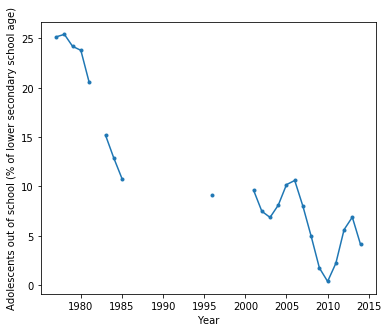

In [23]:
plot_country_indicator(countries[100], indicators[50])

Note something here -- it's masking data that doesn't exist in the dataset.  Those points appear as discontinuities.  This isn't always what we want; for instance, we may instead wish to show those as a continuous, but irregularly spaced, line plot.  However, in this case, we want to emphasize the discontinuity.

Now, we'll use ipywidgets to change which country and indicator we plot.  This isn't *incredibly* useful, since the number of indicators is intimidatingly long, but we will use it as a quick way to explore some of the data.

Note that we're calling `tolist()` on these.  If we just feed in arrays, the `interact` function gets a bit confused.

<function __main__.plot_country_indicator>

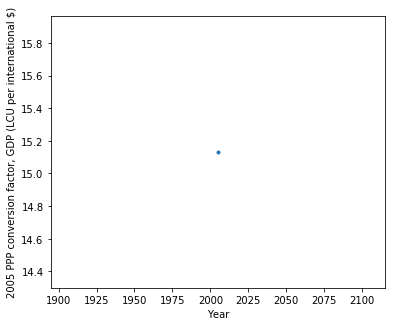

In [24]:
ipywidgets.interact(plot_country_indicator,
                   country=countries.tolist(),
                    indicator=indicators.tolist())

Let's just toss everything into a single plot.  This is a bad idea, and let's demonstrate why.

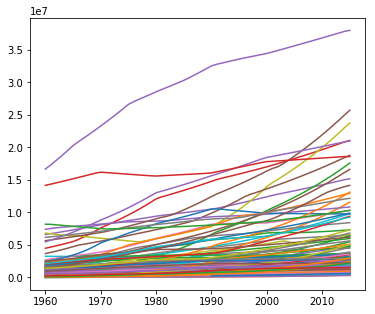

In [25]:
plt.plot(years, pop_city["values"].transpose())

Instead, we'll create a function that plots only those whose countries whose values were greater than those in the US in a given year.  For instance, if you specify 1968, only those countries whose population was greater than the US in 1968 will be plotted.

In [26]:
def greater_than_year(year = 2010):
    year = str(year)
    greater_than_us = pop_city.filter_gt(year, us_pop_city[year])
    for i, country in enumerate(greater_than_us["Country Name"]):
        plt.plot(years, greater_than_us["values"][i,:], label=country)
    plt.ylim(0, np.nanmax(pop_city["values"]))
    plt.legend()

Again, we'll use `ipywidgets.interact` to do this.

/srv/nbgrader/data/WDI/my_dataset.py:41: RuntimeWarning: invalid value encountered in greater
  good = (self.data[column] > value)


<function __main__.greater_than_year>

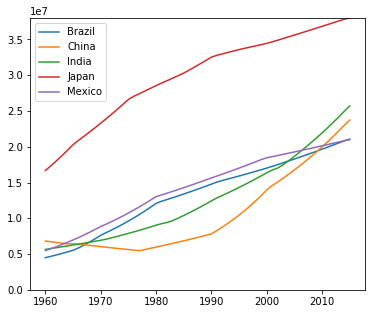

In [27]:
ipywidgets.interact(greater_than_year, year = (1960, 2016))

Now let's see if we can get the top N countries for a given indicator.  Note that we're doing a couple things here that we've done in the past, but in a more optimized form.

Inside our routine, we're filtering out the indicator name that we're given.  We then compute the maximum along all years for each country, then we sort that maximum.  We then iterate over the sorted list, in opposite order, and plot those countries.

In [28]:
def plot_country_indicator_top(indicator, top = 5):
    indicator_value = data.filter_eq("Indicator Name", indicator)
    max_value = np.nanmax(indicator_value["values"], axis=1)
    max_value[np.isnan(max_value)] = -1e90
    max_indices = np.argsort(max_value)
    for ind in reversed(max_indices[-top:]):
        plt.plot(years, indicator_value["values"][ind,:], '.-',
                label=indicator_value["Country Name"][ind])
    plt.xlabel("Year")
    plt.legend()
    plt.ylabel(indicator)

/opt/conda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


<function __main__.plot_country_indicator_top>

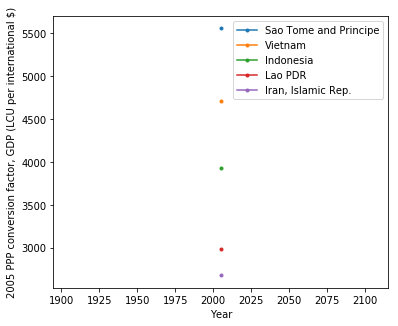

In [29]:
ipywidgets.interact(plot_country_indicator_top,
                   country=countries.tolist(),
                    indicator=indicators.tolist())

Let's see which indicators might be interesting -- specifically, let's take a look at all the indicators that have "Population" in their name.

In [30]:
for indicator in indicators:
    if "Population" in indicator:
        print(indicator)

Population ages 0-14 (% of total)
Population ages 15-64 (% of total)
Population ages 65 and above (% of total)
Population density (people per sq. km of land area)
Population growth (annual %)
Population in largest city
Population in the largest city (% of urban population)
Population in urban agglomerations of more than 1 million
Population in urban agglomerations of more than 1 million (% of total population)
Population living in areas where elevation is below 5 meters (% of total population)
Population living in slums, (% of urban population)
Population, female (% of total)
Population, total


We have lots of options.  So, let's filter out a couple of them -- we'll get the three components of population.  These should all add up to 100%, so we'll use them as an example of how to do stacked plots.

The three components we'll pull out are the age between 0-14, 15-64, and 65 and above.  We'll do this for the United States.  (But, remember, you could extend this to select the country as well!)

In [31]:
united_states = data.filter_eq("Country Name", "United States")
us_pop_0014 = united_states.filter_eq("Indicator Name", "Population ages 0-14 (% of total)")
us_pop_1564 = united_states.filter_eq("Indicator Name", "Population ages 15-64 (% of total)")
us_pop_6500 = united_states.filter_eq("Indicator Name", "Population ages 65 and above (% of total)")

We'll make a simple plot first, just to see the trends.

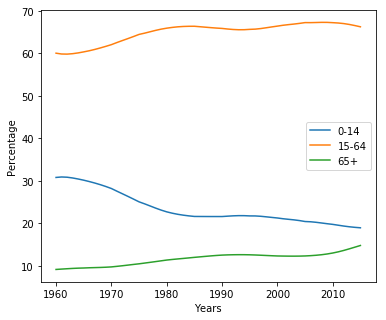

In [32]:
plt.plot(years, us_pop_0014["values"][0,:], label="0-14")
plt.plot(years, us_pop_1564["values"][0,:], label="15-64")
plt.plot(years, us_pop_6500["values"][0,:], label="65+")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Percentage")

Probably not a huge surprise, since the age range 15-64 is quite big.  Let's verify that these sum up to 100%.

In [33]:
us_pop_0014["values"][0,:] + us_pop_1564["values"][0,:] + us_pop_6500["values"][0,:]

array([ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,   nan])

Yup, looks like.  Now we'll make a stackplot.  This is a plot where we're showing the area included in each, and putting one on top of the other.  This type of plot is useful for when you want to show the variation in composition over time of different quantities.

(0, 100)

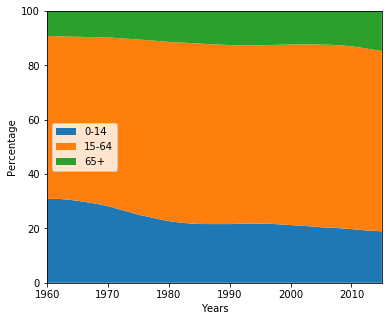

In [34]:
plt.stackplot(years,
              us_pop_0014["values"][0,:],
              us_pop_1564["values"][0,:],
              us_pop_6500["values"][0,:],
             labels = ["0-14", "15-64", "65+"])
plt.legend(loc="center left")
plt.xlabel("Years")
plt.ylabel("Percentage")
plt.xlim(1960, 2015)
plt.ylim(0, 100)

We can plot both the line plots and the stacked plots next to each other to get a more visual comparison between them.

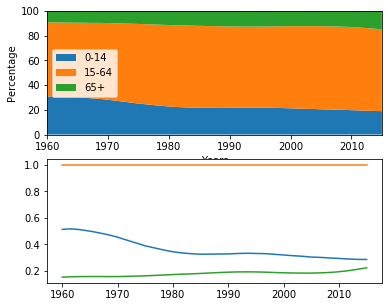

In [35]:
baseline = us_pop_1564["values"][0,:]
plt.subplot(2,1,1)
plt.stackplot(years,
              us_pop_0014["values"][0,:],
              us_pop_1564["values"][0,:],
              us_pop_6500["values"][0,:],
             labels = ["0-14", "15-64", "65+"])
plt.legend(loc="center left")
plt.xlabel("Years")
plt.ylabel("Percentage")
plt.xlim(1960, 2015)
plt.ylim(0, 100)
plt.subplot(2,1,2)
plt.plot(years, us_pop_0014["values"][0,:]/baseline)
plt.plot(years, us_pop_1564["values"][0,:]/baseline)
plt.plot(years, us_pop_6500["values"][0,:]/baseline)

What about things that don't "stack" to a constant value, but a value varying over time?  We can also use a stack plot here, which shows the trendlines, but note that it's not always going to be as clearly demonstrative of the relative percentages.  While it shows composition, extracting from that the specific composition is not trivial.

In [36]:
pop_urban = united_states.filter_eq("Indicator Name", "Population in urban agglomerations of more than 1 million")
pop_total = united_states.filter_eq("Indicator Name", "Population, total")
pop_urban = pop_urban["values"][0,:]
pop_total = pop_total["values"][0,:]
pop_non_urban = pop_total - pop_urban

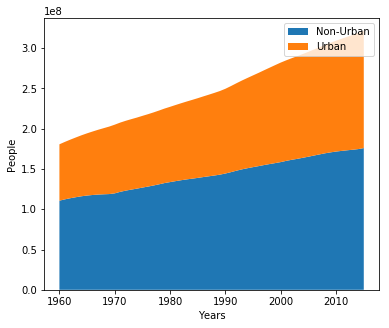

In [37]:
plt.stackplot(years, pop_non_urban, pop_urban, labels=["Non-Urban", "Urban"])
plt.xlabel("Years")
plt.ylabel("People")
plt.legend()